In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('kick.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41476 entries, 0 to 41475
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PurchaseID                         41476 non-null  int64  
 1   PurchaseTimestamp                  41476 non-null  int64  
 2   PurchaseDate                       41476 non-null  object 
 3   Auction                            41432 non-null  object 
 4   VehYear                            41432 non-null  float64
 5   Make                               41432 non-null  object 
 6   Color                              41432 non-null  object 
 7   Transmission                       41432 non-null  object 
 8   WheelTypeID                        41432 non-null  object 
 9   WheelType                          41380 non-null  object 
 10  VehOdo                             41432 non-null  float64
 11  Nationality                        41432 non-null  obj

C:\Users\chj91\AppData\Local\Temp\ipykernel_19876\1827637529.py:4: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('kick.csv')


In [2]:
df_original = df.copy()

In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41476 entries, 0 to 41475
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PurchaseID                         41476 non-null  int64  
 1   PurchaseTimestamp                  41476 non-null  int64  
 2   PurchaseDate                       41476 non-null  object 
 3   Auction                            41432 non-null  object 
 4   VehYear                            41432 non-null  float64
 5   Make                               41432 non-null  object 
 6   Color                              41432 non-null  object 
 7   Transmission                       41432 non-null  object 
 8   WheelTypeID                        41432 non-null  object 
 9   WheelType                          41380 non-null  object 
 10  VehOdo                             41432 non-null  float64
 11  Nationality                        41432 non-null  obj

In [4]:
# Auction: imputation(nan -> OTHER)
df['Auction'] = df['Auction'].fillna('OTHER')

# VehYear: imputation(nan -> median)
df['VehYear'] = df['VehYear'].fillna(df['VehYear'].median())

# Transmission: imputation (?, nan -> UNKNOWN)
df['Transmission'] = df['Transmission'].str.upper()
df['Transmission'] = df['Transmission'].replace('?',np.nan)
df['Transmission'] = df['Transmission'].fillna('UNKNOWN')

# Make: imputation(nan -> UNKNOWN)
df['Make'] = df['Make'].fillna('UNKNOWN')

# VehOdo: imputation(replace outliers with the median value)
lower_bound = 1000
upper_bound = 400000

vehodo_median = df['VehOdo'].median()

df.loc[(df['VehOdo'] < lower_bound)|(df['VehOdo'] > upper_bound), 'VehOdo'] = np.nan

df['VehOdo'] = df['VehOdo'].fillna(vehodo_median)

# Nationality: imputation(USA -> AMERICAN, ? -> nan, nan ->UNKNOWN)
df['Nationality'] = df['Nationality'].str.upper().str.strip()
df['Nationality'] = df['Nationality'].replace('USA', 'AMERICAN')
df['Nationality'] = df['Nationality'].replace('?', np.nan)
df['Nationality'] = df['Nationality'].fillna('UNKNOWN')

# TopThreeAmericanName: imputation(? -> nan, nan -> UNKNOWN)
df['TopThreeAmericanName'] = df['TopThreeAmericanName'].replace('?', np.nan)
df['TopThreeAmericanName'] = df['TopThreeAmericanName'].fillna('UNKNOWN')

# ForSale: upper, imputation(?,0 -> nan / nan-> UNKNOWN)
df['ForSale'] = df['ForSale'].str.upper().str.strip()
df['ForSale'] = df['ForSale'].replace('?', np.nan)
df['ForSale'] = df['ForSale'].replace('0', np.nan)
for_sale_map = {'YES': 0, 'NO': 1}
df['ForSale'] = df['ForSale'].map(for_sale_map)
df['ForSale'] = df['ForSale'].fillna('UNKNOWN')

# MMR Prices
# imputation: ?,0-> nan / change to number /nan -> median value
mmr_current_cols = ['MMRCurrentAuctionAveragePrice','MMRCurrentAuctionCleanPrice', 
                    'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']

for col in mmr_current_cols:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].replace('?', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].replace(0, np.nan)
    df[col] = df[col].fillna(df[col].median())

mmr_acquisition_cols = ['MMRAcquisitionAuctionAveragePrice','MMRAcquisitionAuctionCleanPrice', 
                    'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice']

for col in mmr_acquisition_cols:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].replace('?', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].replace(0, np.nan)
    df[col] = df[col].fillna(df[col].median())

# outlier: quantile 1% and 99%  -> nan -> median value
for col in mmr_current_cols + mmr_acquisition_cols:
    lower_limit = df[col].quantile(0.01)
    upper_limit = df[col].quantile(0.99)
    df.loc[(df[col] < lower_limit) | (df[col] > upper_limit), col] = np.nan
    df[col] = df[col].fillna(df[col].median())

In [5]:
print(df['ForSale'].describe())
print(df['ForSale'].unique())
print(df['ForSale'].value_counts())
print(df['VehOdo'].value_counts(bins=10)) #only numeric data

count     41476.0
unique        3.0
top           0.0
freq      41470.0
Name: ForSale, dtype: float64
[0.0 1.0 'UNKNOWN']
ForSale
0.0        41470
UNKNOWN        4
1.0            2
Name: count, dtype: int64
(71360.2, 82449.4]      12580
(60271.0, 71360.2]       9339
(82449.4, 93538.6]       8554
(49181.8, 60271.0]       5815
(38092.6, 49181.8]       2932
(93538.6, 104627.8]      1546
(27003.4, 38092.6]        541
(15914.2, 27003.4]         82
(104627.8, 115717.0]       74
(4714.107, 15914.2]        13
Name: count, dtype: int64


In [6]:
selected_cols = ['Auction', 'VehYear', 'Make', 'Transmission', 'VehOdo',
                 'Nationality', 'TopThreeAmericanName',
                 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
                 'MMRCurrentRetailRatio', 'ForSale', 'IsBadBuy']
df_selected = df[selected_cols].copy()
print(df_selected.describe())
print("================================================================")
for col in df_selected.columns:
    print(df_selected[col].unique())

            VehYear         VehOdo  MMRCurrentAuctionAveragePrice  \
count  41476.000000   41476.000000                   41476.000000   
mean    2005.360232   71293.878918                    6151.082337   
std        1.729709   14574.440942                    2187.503398   
min     2001.000000    4825.000000                    2017.000000   
25%     2004.000000   61594.750000                    4426.000000   
50%     2005.000000   73128.500000                    6101.500000   
75%     2007.000000   82243.750000                    7678.000000   
max     2010.000000  115717.000000                   12627.000000   

       MMRCurrentAuctionCleanPrice  MMRCurrentRetailAveragePrice  \
count                 41476.000000                  41476.000000   
mean                   7400.877254                   8795.110908   
std                    2401.699216                   2788.122496   
min                    2734.000000                   2970.000000   
25%                    5569.750000    

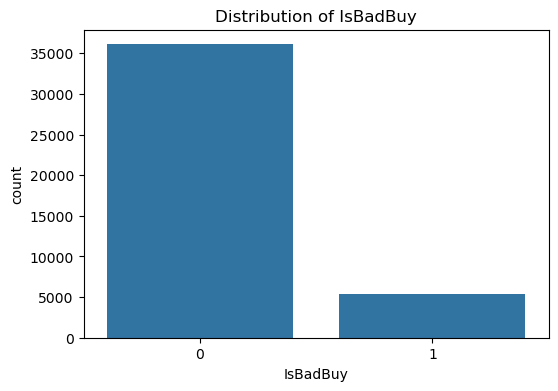

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='IsBadBuy')
plt.title('Distribution of IsBadBuy')
plt.show()

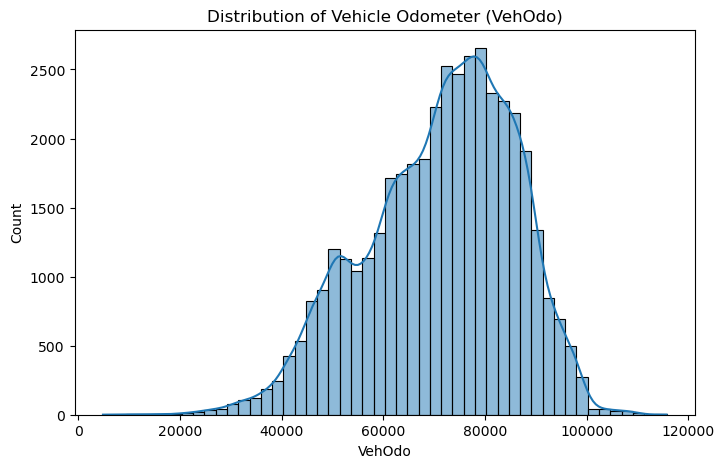

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(df['VehOdo'], kde=True, bins=50)
plt.title('Distribution of Vehicle Odometer (VehOdo)')
plt.xlabel('VehOdo')
plt.ylabel('Count')
plt.show()

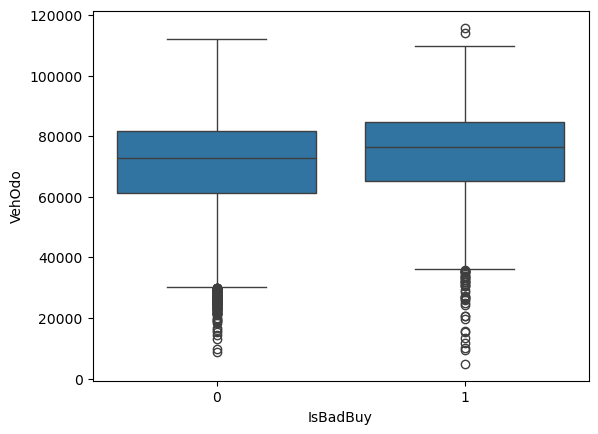

In [9]:
ax = sns.boxplot(x="IsBadBuy", y="VehOdo", data=df)
plt.show()

In [10]:
correlation_matrix = df[mmr_current_cols + mmr_acquisition_cols].corr()
correlation_matrix

MMRCurrentAuctionAveragePrice  \
MMRCurrentAuctionAveragePrice                           1.000000   
MMRCurrentAuctionCleanPrice                             0.970569   
MMRCurrentRetailAveragePrice                            0.864111   
MMRCurrentRetailCleanPrice                              0.858258   
MMRAcquisitionAuctionAveragePrice                       0.920317   
MMRAcquisitionAuctionCleanPrice                         0.901959   
MMRAcquisitionRetailAveragePrice                        0.810090   
MMRAcquisitonRetailCleanPrice                           0.805666   

                                   MMRCurrentAuctionCleanPrice  \
MMRCurrentAuctionAveragePrice                         0.970569   
MMRCurrentAuctionCleanPrice                           1.000000   
MMRCurrentRetailAveragePrice                          0.853295   
MMRCurrentRetailCleanPrice                            0.869302   
MMRAcquisitionAuctionAveragePrice                     0.909658   
MMRAcquisitionAuctionCleanPrice                       0.917228   
MMRAcquisitionRetailAveragePrice                      0.806338   
MMRAcquisitonRetailCleanPrice                         0.815212   

                                   MMRCurrentRetailAveragePrice  \
MMRCurrentAuctionAveragePrice                          0.864111   
MMRCurrentAuctionCleanPrice                            0.853295   
MMRCurrentRetailAveragePrice                           1.000000   
MMRCurrentRetailCleanPrice                             0.971210   
MMRAcquisitionAuctionAveragePrice                      0.834879   
MMRAcquisitionAuctionCleanPrice                        0.822289   
MMRAcquisitionRetailAveragePrice                       0.895152   
MMRAcquisitonRetailCleanPrice                          0.881332   

                                   MMRCurrentRetailCleanPrice  \
MMRCurrentAuctionAveragePrice                        0.858258   
MMRCurrentAuctionCleanPrice                          0.869302   
MMRCurrentRetailAveragePrice                         0.971210   
MMRCurrentRetailCleanPrice                           1.000000   
MMRAcquisitionAuctionAveragePrice                    0.833149   
MMRAcquisitionAuctionCleanPrice                      0.835218   
MMRAcquisitionRetailAveragePrice                     0.885160   
MMRAcquisitonRetailCleanPrice                        0.887494   

                                   MMRAcquisitionAuctionAveragePrice  \
MMRCurrentAuctionAveragePrice                               0.920317   
MMRCurrentAuctionCleanPrice                                 0.909658   
MMRCurrentRetailAveragePrice                                0.834879   
MMRCurrentRetailCleanPrice                                  0.833149   
MMRAcquisitionAuctionAveragePrice                           1.000000   
MMRAcquisitionAuctionCleanPrice                             0.969953   
MMRAcquisitionRetailAveragePrice                            0.856321   
MMRAcquisitonRetailCleanPrice                               0.854305   

                                   MMRAcquisitionAuctionCleanPrice  \
MMRCurrentAuctionAveragePrice                             0.901959   
MMRCurrentAuctionCleanPrice                               0.917228   
MMRCurrentRetailAveragePrice                              0.822289   
MMRCurrentRetailCleanPrice                                0.835218   
MMRAcquisitionAuctionAveragePrice                         0.969953   
MMRAcquisitionAuctionCleanPrice                           1.000000   
MMRAcquisitionRetailAveragePrice                          0.844286   
MMRAcquisitonRetailCleanPrice                             0.861817   

                                   MMRAcquisitionRetailAveragePrice  \
MMRCurrentAuctionAveragePrice                              0.810090   
MMRCurrentAuctionCleanPrice                                0.806338   
MMRCurrentRetailAveragePrice                               0.895152   
MMRCurrentRetailCleanPrice                                 0.885160   
MM

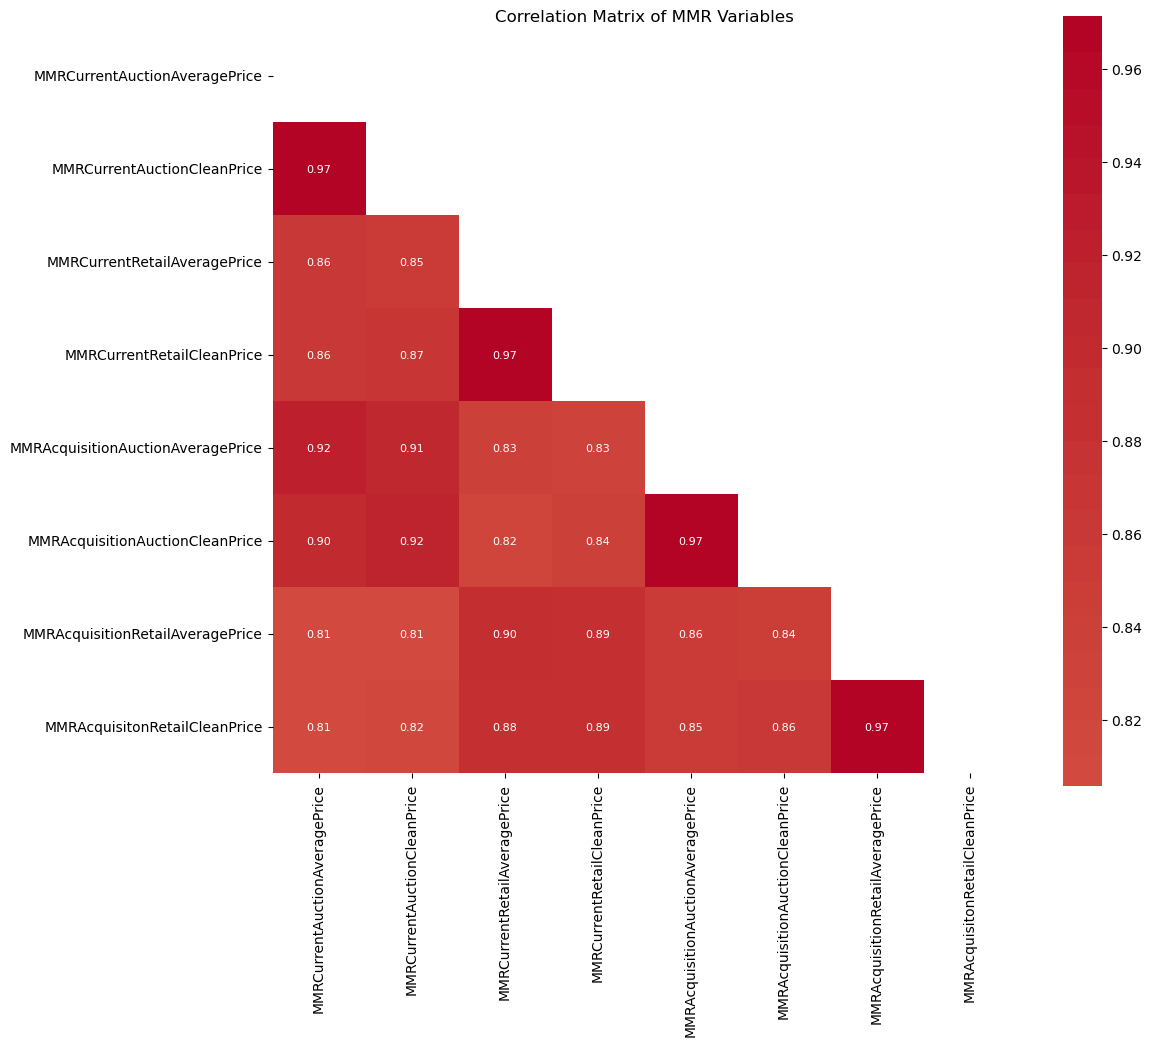

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", 
            annot_kws={'size': 8}, cmap='coolwarm', 
            center=0, mask=correlation_mask, square=True)
plt.title('Correlation Matrix of MMR Variables')
plt.show()
# we use one value of MMR variables

In [12]:
# the result between before and after preprocessing
df_selected_original = df_original[selected_cols].copy()
df_selected_processed = df[selected_cols].copy()

for col in selected_cols:
    print(f"===== Column: {col}========")
    if df[col].dtype in ['int64', 'float64']:
        print("Before preprocessing:")
        print(df_selected_original[col].describe())
        print("====================================")
        print("After preprocessing:")
        print(df_selected_processed[col].describe())
    else:
        print("Before preprocessing:")
        print(df_selected_original[col].value_counts(dropna=False))
        print("====================================")
        print("After preprocessing:")
        print(df_selected_processed[col].value_counts(dropna=False))
    print("\n")

===== Column: Auction========
Before preprocessing:
Auction
MANHEIM    22168
ADESA      11086
OTHER       8178
NaN           44
Name: count, dtype: int64
After preprocessing:
Auction
MANHEIM    22168
ADESA      11086
OTHER       8222
Name: count, dtype: int64


===== Column: VehYear========
Before preprocessing:
count    41432.000000
mean      2005.360615
std          1.730587
min       2001.000000
25%       2004.000000
50%       2005.000000
75%       2007.000000
max       2010.000000
Name: VehYear, dtype: float64
After preprocessing:
count    41476.000000
mean      2005.360232
std          1.729709
min       2001.000000
25%       2004.000000
50%       2005.000000
75%       2007.000000
max       2010.000000
Name: VehYear, dtype: float64


===== Column: Make========
Before preprocessing:
Make
CHEVROLET     9548
DODGE         7385
FORD          6458
CHRYSLER      5259
PONTIAC       2355
KIA           1337
SATURN        1245
NISSAN        1186
JEEP           985
HYUNDAI        957
SUZUKI 

In [13]:
categorical_cols = ['Auction', 'Make', 'Transmission', 'Nationality', 
                    'TopThreeAmericanName', 'ForSale']
for col in categorical_cols:
    print(f"=== {col} ===")
    print("*** Before preprocessing ***")
    print(df_original.groupby('IsBadBuy')[col].value_counts(normalize=True))
    print("-----------------------------")
    print("*** After preprocessing ***")
    print(df.groupby('IsBadBuy')[col].value_counts(normalize=True))
    print("======================================\n")

# the proportion of values of the target variable 

=== Auction ===
*** Before preprocessing ***
IsBadBuy  Auction
0         MANHEIM    0.541825
          ADESA      0.258657
          OTHER      0.199518
1         MANHEIM    0.489469
          ADESA      0.327493
          OTHER      0.183038
Name: proportion, dtype: float64
-----------------------------
*** After preprocessing ***
IsBadBuy  Auction
0         MANHEIM    0.541255
          ADESA      0.258385
          OTHER      0.200360
1         MANHEIM    0.488922
          ADESA      0.327127
          OTHER      0.183951
Name: proportion, dtype: float64

=== Make ===
*** Before preprocessing ***
IsBadBuy  Make      
0         CHEVROLET     0.238085
          DODGE         0.182078
          FORD          0.149361
          CHRYSLER      0.126459
          PONTIAC       0.057476
          KIA           0.032329
          SATURN        0.029390
          NISSAN        0.027782
          JEEP          0.022874
          HYUNDAI       0.022763
          SUZUKI        0.019907
        

In [14]:
numeric_cols = ['VehYear', 'VehOdo', 'MMRCurrentAuctionAveragePrice','MMRCurrentAuctionCleanPrice', 
                'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']
for col in numeric_cols:
    print(f"=== {col} ===")
    print("*** Before preprocessing ***")
    print(df_original.groupby('IsBadBuy')[col].describe())
    print("-----------------------------")
    print("*** After preprocessing ***")
    print(df.groupby('IsBadBuy')[col].describe())
    print("======================================\n")

=== VehYear ===
*** Before preprocessing ***
            count         mean       std     min     25%     50%     75%  \
IsBadBuy                                                                   
0         36067.0  2005.471151  1.697094  2001.0  2004.0  2006.0  2007.0   
1          5365.0  2004.617521  1.770015  2001.0  2003.0  2005.0  2006.0   

             max  
IsBadBuy          
0         2010.0  
1         2009.0  
-----------------------------
*** After preprocessing ***
            count         mean       std     min     25%     50%     75%  \
IsBadBuy                                                                   
0         36105.0  2005.470655  1.696270  2001.0  2004.0  2006.0  2007.0   
1          5371.0  2004.617948  1.769072  2001.0  2003.0  2005.0  2006.0   

             max  
IsBadBuy          
0         2010.0  
1         2009.0  

=== VehOdo ===
*** Before preprocessing ***
            count          mean           std     min      25%      50%  \
IsBadBuy       

In [15]:
drop_cols = [
    'PurchaseID', 'PurchaseTimestamp', 'PurchaseDate', 'Make',
    'Color', 'WheelTypeID', 'WheelType', 'Size', 'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 
    'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailCleanPrice', 
    'MMRCurrentRetailRatio', 'WarrantyCost', 'ForSale',
    'PRIMEUNIT', 'AUCGUART', 'VNST', 'VehBCost', 'IsOnlineSale'
]
df.drop(columns=drop_cols, axis=1, inplace=True)


In [16]:
print(df.columns)
print(df.isnull().sum())

Index(['Auction', 'VehYear', 'Transmission', 'VehOdo', 'Nationality',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentRetailAveragePrice',
       'IsBadBuy'],
      dtype='object')
Auction                          0
VehYear                          0
Transmission                     0
VehOdo                           0
Nationality                      0
MMRCurrentAuctionAveragePrice    0
MMRCurrentRetailAveragePrice     0
IsBadBuy                         0
dtype: int64


In [17]:
df = pd.get_dummies(df)

In [18]:
y = df['IsBadBuy'].values
X = df.drop('IsBadBuy', axis=1)
feature_names =X.columns
X = X.values

In [19]:
from sklearn.model_selection import train_test_split
random_state = 10
test_set_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=random_state)

print("Size of training set:", len(X_train))
print("Size of testing set:", len(X_test))

Size of training set: 29033
Size of testing set: 12443


In [20]:
from sklearn.tree import DecisionTreeClassifier

#simple decision tree training
model = DecisionTreeClassifier(random_state=random_state)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=10)

In [21]:
print('****Model parameters*****\n', model.get_params(deep=True))
print('Number of leaves in the trained model:', model.get_n_leaves())
print("Number of nodes:", model.tree_.node_count)

****Model parameters*****
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 10, 'splitter': 'best'}
Number of leaves in the trained model: 4999
Number of nodes: 9997


In [22]:
print("Training set accuracy:", model.score(X_train, y_train)) #overfitting
print("Testing set accuracy:", model.score(X_test, y_test))

Training set accuracy: 0.9998277821788999
Testing set accuracy: 0.7807602668166841


In [23]:
y_pred = model.predict(X_test)
print(y_pred)

[0 0 0 ... 1 1 0]


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87     10832
           1       0.18      0.19      0.18      1611

    accuracy                           0.78     12443
   macro avg       0.53      0.53      0.53     12443
weighted avg       0.79      0.78      0.78     12443



In [25]:
def display_feature_importances(model, feature_names, features_to_display=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    indices = indices[:features_to_display]
    for i in indices:
        print(feature_names[i], ':', importances[i])
    print("Number of leaves:", model.get_n_leaves())
    
display_feature_importances(model, feature_names)

VehOdo : 0.36932140555782883
MMRCurrentRetailAveragePrice : 0.2659883719680745
MMRCurrentAuctionAveragePrice : 0.24943085804225154
VehYear : 0.042967744090411944
Auction_OTHER : 0.015423279634537651
Auction_MANHEIM : 0.0129631752570289
Auction_ADESA : 0.010884338151795542
Nationality_AMERICAN : 0.009273743181650274
Nationality_OTHER ASIAN : 0.009260489473204996
Nationality_TOP LINE ASIAN : 0.006488607453676483
Transmission_AUTO : 0.0036549128945540465
Transmission_MANUAL : 0.0032932079964304224
Nationality_OTHER : 0.001049866298554846
Transmission_UNKNOWN : 0.0
Nationality_UNKNOWN : 0.0
Number of leaves: 4999


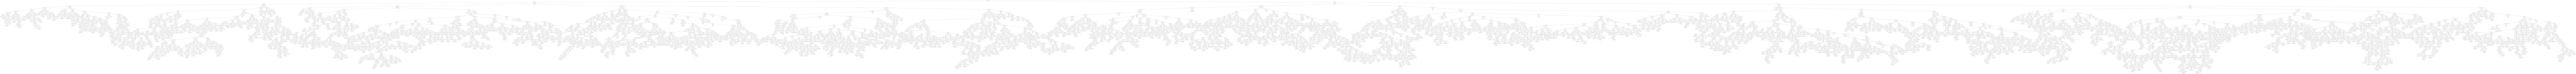

In [26]:
from IPython.display import Image, display
from io import StringIO
from sklearn.tree import export_graphviz
import pydot

def visualize_model(model):
    dotfile = StringIO()
    export_graphviz(model, out_file=dotfile, feature_names=feature_names)

    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    display(Image(graph[0].create_png()))

visualize_model(model)

In [27]:
model_small = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=5,
    random_state=random_state
) 

model_small.fit(X_train, y_train)

y_pred =model_small.predict(X_test)
print(classification_report(y_test, y_pred))

# Node, leaves, depth
print("Nodes:", model_small.tree_.node_count)
print("Leaves:", model_small.get_n_leaves())
print("Depth:", model_small.get_depth())

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10832
           1       0.00      0.00      0.00      1611

    accuracy                           0.87     12443
   macro avg       0.44      0.50      0.47     12443
weighted avg       0.76      0.87      0.81     12443

Nodes: 15
Leaves: 8
Depth: 3


C:\Users\chj91\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chj91\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chj91\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
model_small = DecisionTreeClassifier(
    max_depth=3, 
    class_weight='balanced',
    random_state=random_state
) 
#'class_weight'can balance the class

model_small.fit(X_train, y_train)

y_pred =model_small.predict(X_test)
print(classification_report(y_test, y_pred))

# Node, leaves, depth
print("Nodes:", model_small.tree_.node_count)
print("Leaves:", model_small.get_n_leaves())
print("Depth:", model_small.get_depth())

              precision    recall  f1-score   support

           0       0.91      0.63      0.74     10832
           1       0.19      0.57      0.28      1611

    accuracy                           0.62     12443
   macro avg       0.55      0.60      0.51     12443
weighted avg       0.82      0.62      0.68     12443

Nodes: 15
Leaves: 8
Depth: 3


VehYear : 0.7661573891371191
MMRCurrentAuctionAveragePrice : 0.11149221549044215
VehOdo : 0.0731100508607268
Auction_ADESA : 0.029442055720801594
Auction_MANHEIM : 0.01979828879091031
Nationality_TOP LINE ASIAN : 0.0
Nationality_UNKNOWN : 0.0
Transmission_MANUAL : 0.0
Transmission_UNKNOWN : 0.0
Nationality_AMERICAN : 0.0
Nationality_OTHER : 0.0
Nationality_OTHER ASIAN : 0.0
Auction_OTHER : 0.0
Transmission_AUTO : 0.0
MMRCurrentRetailAveragePrice : 0.0
Number of leaves: 8


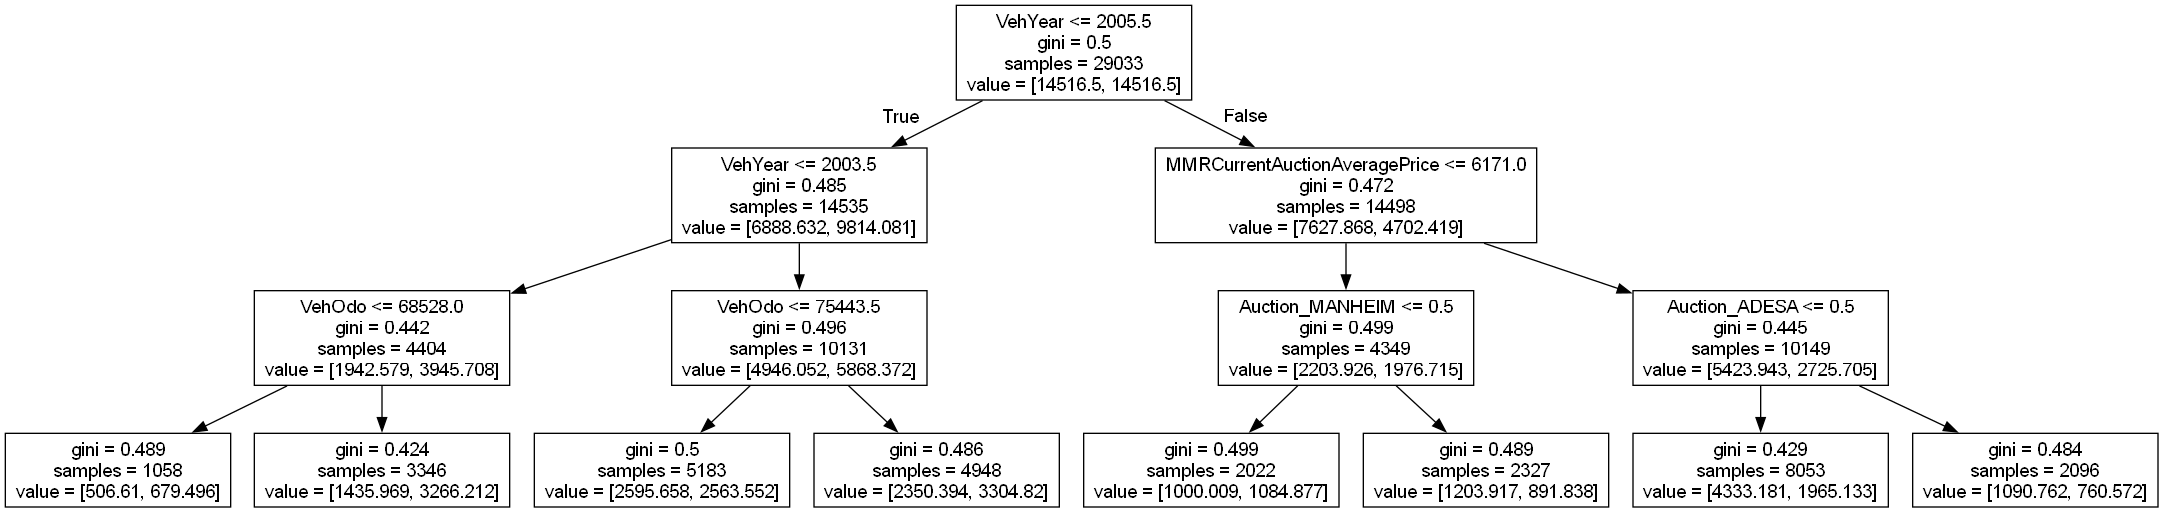

In [29]:
display_feature_importances(model_small, feature_names)
visualize_model(model_small)

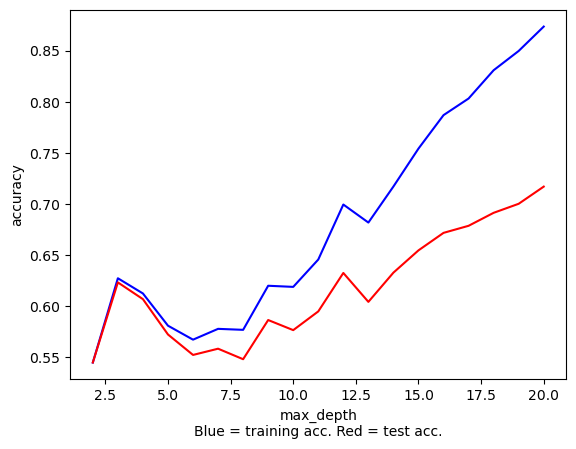

In [30]:
import matplotlib.pyplot as plt

test_score = []
train_score = []
for max_depth in range(2,21):
    temp_model = DecisionTreeClassifier(max_depth=max_depth, class_weight="balanced", random_state=random_state)
    temp_model.fit(X_train, y_train)
    test_score.append(temp_model.score(X_test, y_test))
    train_score.append(temp_model.score(X_train, y_train))

plt.plot(range(2,21), train_score, 'b', range(2,21), test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.show()

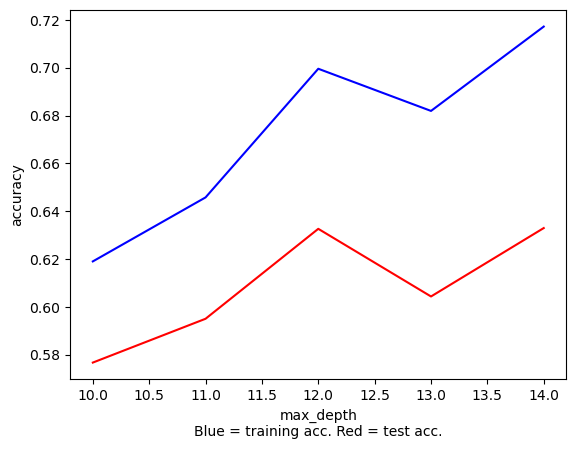

In [31]:
import matplotlib.pyplot as plt

test_score = []
train_score = []
for max_depth in range(10,15):
    temp_model = DecisionTreeClassifier(max_depth=max_depth, class_weight="balanced", random_state=random_state)
    temp_model.fit(X_train, y_train)
    test_score.append(temp_model.score(X_test, y_test))
    train_score.append(temp_model.score(X_train, y_train))

plt.plot(range(10,15), train_score, 'b', range(10,15), test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.show()

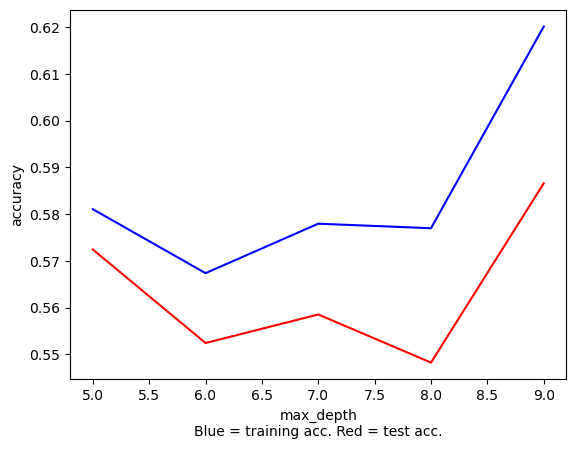

In [32]:
import matplotlib.pyplot as plt

test_score = []
train_score = []
for max_depth in range(5,10):
    temp_model = DecisionTreeClassifier(max_depth=max_depth, class_weight="balanced", random_state=random_state)
    temp_model.fit(X_train, y_train)
    test_score.append(temp_model.score(X_test, y_test))
    train_score.append(temp_model.score(X_train, y_train))

plt.plot(range(5,10), train_score, 'b', range(5,10), test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.show()

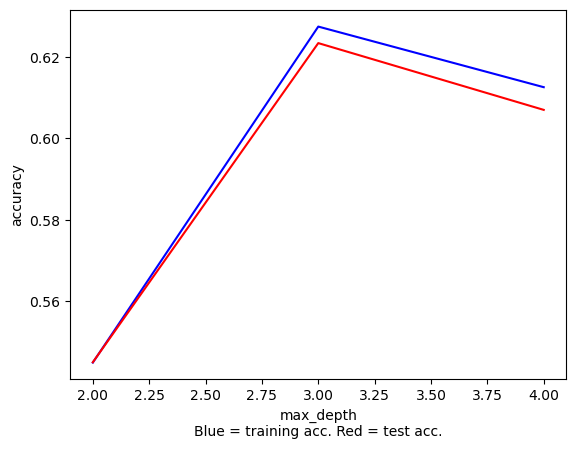

In [33]:
import matplotlib.pyplot as plt

test_score = []
train_score = []
for max_depth in range(2, 5):
    temp_model = DecisionTreeClassifier(max_depth=max_depth, class_weight="balanced", random_state=random_state)
    temp_model.fit(X_train, y_train)
    test_score.append(temp_model.score(X_test, y_test))
    train_score.append(temp_model.score(X_train, y_train))

plt.plot(range(2, 5), train_score, 'b', range(2, 5), test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.show()

In [34]:
from sklearn.model_selection import GridSearchCV
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(10, 15),
    'min_samples_leaf': range(20, 60, 10)
}

def perform_grid_search(X_train, y_train, X_test, y_test, params, num_folds=10):
    cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=random_state, class_weight='balanced'), cv=num_folds, verbose=1, n_jobs=-1)
    cv.fit(X_train,y_train)

    print("Train accuracy:", cv.score(X_train, y_train))
    print("Test accuracy:", cv.score(X_test, y_test))

    y_pred = cv.predict(X_test)
    print(classification_report(y_test, y_pred))

    print(cv.best_params_)
    return cv
    
cv = perform_grid_search(X_train, y_train, X_test, y_test, params)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Train accuracy: 0.652705541969483
Test accuracy: 0.5902917302901229
              precision    recall  f1-score   support

           0       0.90      0.60      0.72     10832
           1       0.17      0.56      0.26      1611

    accuracy                           0.59     12443
   macro avg       0.53      0.58      0.49     12443
weighted avg       0.81      0.59      0.66     12443

{'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 20}


In [35]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,5),
    'min_samples_leaf': range(5, 20, 10)
}
cv= perform_grid_search(X_train, y_train, X_test, y_test, params)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Train accuracy: 0.6274584093962043
Test accuracy: 0.6234027163867235
              precision    recall  f1-score   support

           0       0.91      0.63      0.74     10832
           1       0.19      0.57      0.28      1611

    accuracy                           0.62     12443
   macro avg       0.55      0.60      0.51     12443
weighted avg       0.82      0.62      0.68     12443

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5}


In [36]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(5,8),
    'min_samples_leaf': range(5, 10)
}
cv = perform_grid_search(X_train, y_train, X_test, y_test, params)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Train accuracy: 0.5778941204835877
Test accuracy: 0.557984408904605
              precision    recall  f1-score   support

           0       0.92      0.54      0.68     10832
           1       0.18      0.67      0.28      1611

    accuracy                           0.56     12443
   macro avg       0.55      0.60      0.48     12443
weighted avg       0.82      0.56      0.63     12443

{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 5}


In [37]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2, 4),
    'min_samples_leaf': range(5, 50, 10)
}
cv= perform_grid_search(X_train, y_train, X_test, y_test, params)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Train accuracy: 0.6274584093962043
Test accuracy: 0.6234027163867235
              precision    recall  f1-score   support

           0       0.91      0.63      0.74     10832
           1       0.19      0.57      0.28      1611

    accuracy                           0.62     12443
   macro avg       0.55      0.60      0.51     12443
weighted avg       0.82      0.62      0.68     12443

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5}


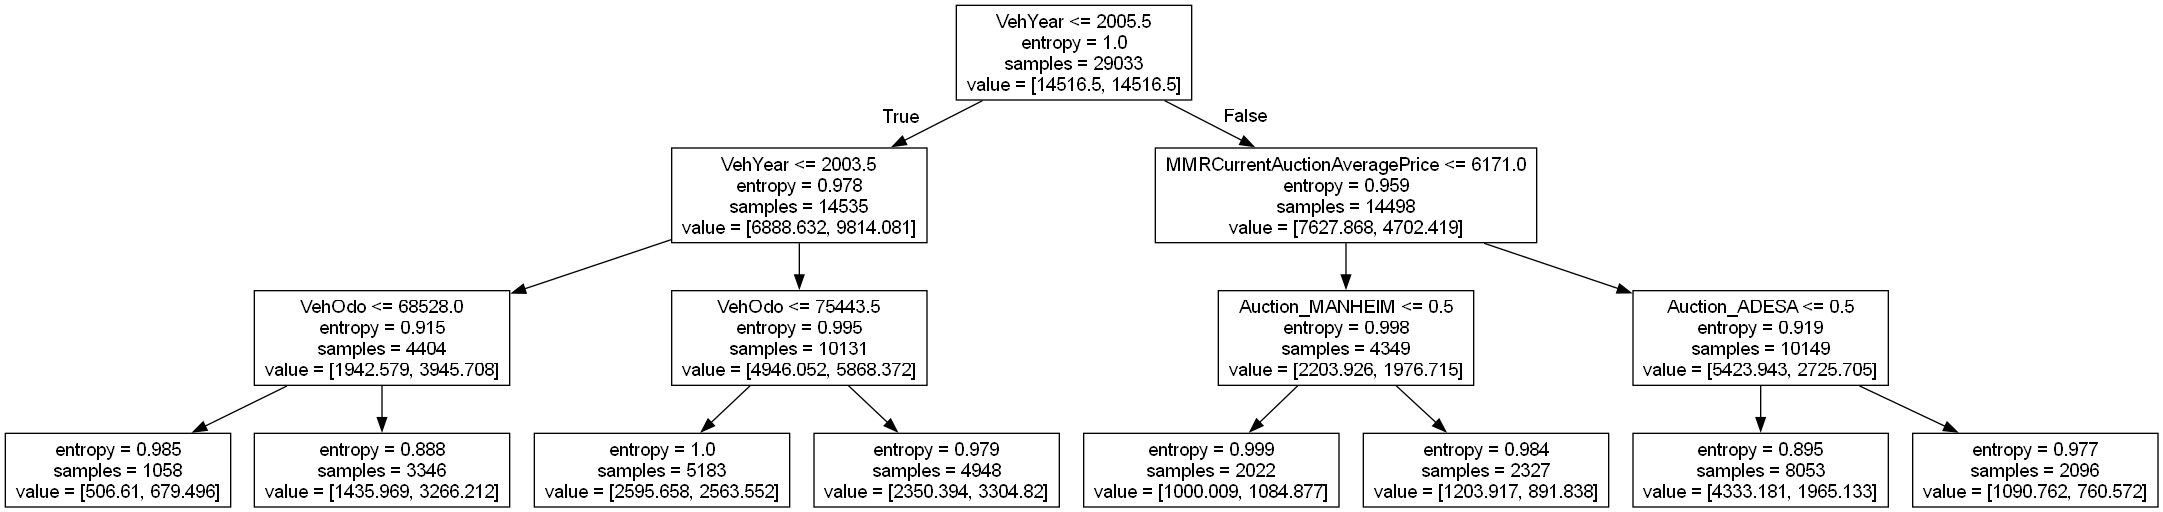

In [38]:
model_cv= cv.best_estimator_
visualize_model(model_cv)

VehYear : 0.7598540857360376
MMRCurrentAuctionAveragePrice : 0.1144055334609266
VehOdo : 0.07466742514630023
Auction_ADESA : 0.03162454160340716
Auction_MANHEIM : 0.019448414053328502
Nationality_TOP LINE ASIAN : 0.0
Nationality_UNKNOWN : 0.0
Transmission_MANUAL : 0.0
Transmission_UNKNOWN : 0.0
Nationality_AMERICAN : 0.0
Nationality_OTHER : 0.0
Nationality_OTHER ASIAN : 0.0
Auction_OTHER : 0.0
Transmission_AUTO : 0.0
MMRCurrentRetailAveragePrice : 0.0
Number of leaves: 8


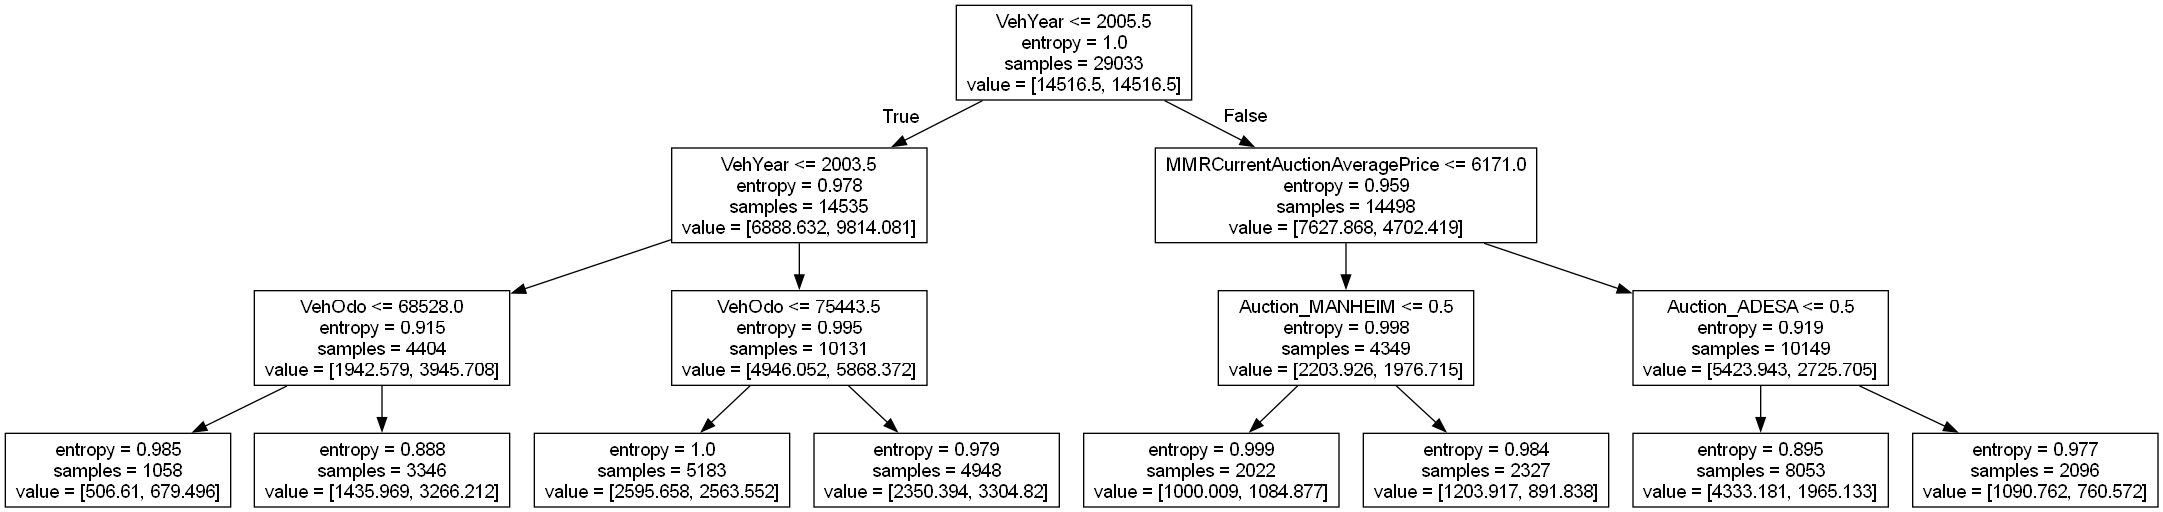

In [39]:
display_feature_importances(model_cv, feature_names)
visualize_model(model_cv)

In [40]:
print("Nodes:", model_cv.tree_.node_count)
print("Leaves:", model_cv.get_n_leaves())
print("Depth:", model_cv.get_depth())

Nodes: 15
Leaves: 8
Depth: 3


In [41]:
y_pred = model_cv.predict(X_test)
y_pred_proba_dt = model_cv.predict_proba(X_test)

print("Probability produced by decision tree for each class vs actual prediction on Target (0 = clean, 1 = BadBuy).")
print("You should be able to see the default threshold of 0.5.")
print("(Probs on zero)  (probs on one)  (prediction made)  (label)")

for i in range(20):
    print(f"{y_pred_proba_dt[i][0]:.13f}  {y_pred_proba_dt[i][1]:.13f}  {y_pred[i]:<10d}  {y_test[i]:10d}")

Probability produced by decision tree for each class vs actual prediction on Target (0 = clean, 1 = BadBuy).
You should be able to see the default threshold of 0.5.
(Probs on zero)  (probs on one)  (prediction made)  (label)
0.6879906587041  0.3120093412960  0                    0
0.4156154219677  0.5843845780323  1                    0
0.6879906587041  0.3120093412960  0                    0
0.5891763039276  0.4108236960725  0                    0
0.5744549010524  0.4255450989477  0                    0
0.5744549010524  0.4255450989477  0                    1
0.4156154219677  0.5843845780323  1                    0
0.6879906587041  0.3120093412960  0                    0
0.6879906587041  0.3120093412960  0                    0
0.3053836076187  0.6946163923813  1                    0
0.5891763039276  0.4108236960725  0                    0
0.6879906587041  0.3120093412960  0                    0
0.3053836076187  0.6946163923813  1                    0
0.4271204043909  0.5728795956091  

In [42]:
from sklearn.metrics import roc_auc_score

y_pred_proba_dt = model.predict_proba(X_test)
y_pred_proba_dt_small = model_small.predict_proba(X_test)
y_pred_proba_dt_cv = model_cv.predict_proba(X_test)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_dt_small = roc_auc_score(y_test, y_pred_proba_dt_small[:, 1])
roc_index_dt_cv = roc_auc_score(y_test, y_pred_proba_dt_cv[:, 1])

print("ROC index on test for default model:", roc_index_dt)
print("ROC index on test for small model:", roc_index_dt_small)
print("ROC index on test for grid search model:", roc_index_dt_cv)

ROC index on test for default model: 0.5288166393434355
ROC index on test for small model: 0.6386763716857975
ROC index on test for grid search model: 0.6386763716857975


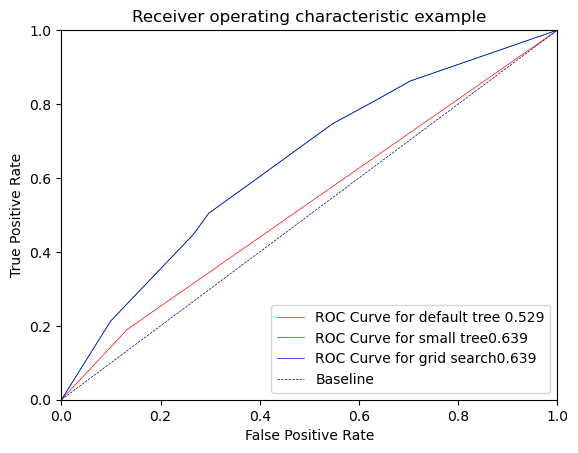

In [43]:
from sklearn.metrics import roc_curve
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_dt_small, tpr_dt_small, thresholds_dt_small = roc_curve(y_test, y_pred_proba_dt_small[:,1])
fpr_dt_cv, tpr_dt_cv, thresholds_dt_cv = roc_curve(y_test, y_pred_proba_dt_cv[:,1])

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for default tree {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_dt_small, tpr_dt_small, label='ROC Curve for small tree{:.3f}'.format(roc_index_dt_small), color='green', lw=0.5)
plt.plot(fpr_dt_cv, tpr_dt_cv, label='ROC Curve for grid search{:.3f}'.format(roc_index_dt_cv), color='blue', lw=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, label='Baseline', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [44]:
import pickle

with open('decision_tree_model.pickle', 'wb') as f:
    pickle.dump([model_cv, roc_index_dt_cv, fpr_dt_cv, tpr_dt_cv], f)

In [45]:
random_state = 10
test_set_size = 0.3 # 30%
print("Size of training set:", len(X_train))
print("Size of testing set:", len(X_test))

Size of training set: 29033
Size of testing set: 12443


In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

print("Before scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".format(i, min(col), max(col), np.mean(col), np.std(col)))

X_train = scaler.fit_transform(X_train, y_train)

print("After scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".format(i, min(col), max(col), np.mean(col), np.std(col)))

X_test = scaler.transform(X_test)

Before scaling
-------------
Variable #0: min 2001.0, max 2010.0, mean 2005.36 and std dev 1.73
Variable #1: min 4825.0, max 115717.0, mean 71311.23 and std dev 14570.61
Variable #2: min 2017.0, max 12623.0, mean 6156.95 and std dev 2188.21
Variable #3: min 2978.0, max 16151.0, mean 8799.11 and std dev 2789.97
Variable #4: min False, max True, mean 0.27 and std dev 0.44
After scaling
-------------
Variable #0: min -2.5182851572014004, max 2.684608421782512, mean -0.00 and std dev 1.00
Variable #1: min -4.563035230327706, max 3.0476255036126663, mean -0.00 and std dev 1.00
Variable #2: min -1.8919368524000326, max 2.954951367499358, mean 0.00 and std dev 1.00
Variable #3: min -2.0864404537378474, max 2.6351132730794915, mean 0.00 and std dev 1.00
Variable #4: min -0.6033342483025691, max 1.6574560499638853, mean 0.00 and std dev 1.00


In [47]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=random_state)

model.fit(X_train, y_train)

LogisticRegression(random_state=10)

In [48]:
from sklearn.metrics import classification_report

print("Training accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Training accuracy: 0.8704921985327042
Test accuracy: 0.8705296150446034
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10832
           1       0.00      0.00      0.00      1611

    accuracy                           0.87     12443
   macro avg       0.44      0.50      0.47     12443
weighted avg       0.76      0.87      0.81     12443



C:\Users\chj91\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chj91\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chj91\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
print(model.coef_)

[[-3.80482352e-01  1.44154028e-01 -9.55704368e-02 -3.82722489e-02
   7.18311029e-02 -8.94640571e-02  3.22948474e-02  3.13379240e-02
  -3.18394075e-02  1.13962487e-04 -3.23985494e-02  2.09531292e-02
   4.18565785e-02 -9.32367921e-03  1.23953710e-04]]


In [50]:
coef = model.coef_[0]

coef = coef[:20]
for i in range(len(coef)):
    print(feature_names[i], ':', coef[i])

VehYear : -0.38048235170043104
VehOdo : 0.1441540280327456
MMRCurrentAuctionAveragePrice : -0.09557043678010708
MMRCurrentRetailAveragePrice : -0.038272248876095545
Auction_ADESA : 0.07183110288718392
Auction_MANHEIM : -0.08946405705092648
Auction_OTHER : 0.032294847364807804
Transmission_AUTO : 0.031337923955090455
Transmission_MANUAL : -0.031839407455609564
Transmission_UNKNOWN : 0.00011396248691740809
Nationality_AMERICAN : -0.032398549403172903
Nationality_OTHER : 0.020953129161431286
Nationality_OTHER ASIAN : 0.04185657853810174
Nationality_TOP LINE ASIAN : -0.009323679205518205
Nationality_UNKNOWN : 0.0001239537095425546


In [51]:
coef = model.coef_[0]

indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

indices = indices[:20]
for i in indices:
    print(feature_names[i], ':', coef[i])

VehYear : -0.38048235170043104
VehOdo : 0.1441540280327456
MMRCurrentAuctionAveragePrice : -0.09557043678010708
Auction_MANHEIM : -0.08946405705092648
Auction_ADESA : 0.07183110288718392
Nationality_OTHER ASIAN : 0.04185657853810174
MMRCurrentRetailAveragePrice : -0.038272248876095545
Nationality_AMERICAN : -0.032398549403172903
Auction_OTHER : 0.032294847364807804
Transmission_MANUAL : -0.031839407455609564
Transmission_AUTO : 0.031337923955090455
Nationality_OTHER : 0.020953129161431286
Nationality_TOP LINE ASIAN : -0.009323679205518205
Nationality_UNKNOWN : 0.0001239537095425546
Transmission_UNKNOWN : 0.00011396248691740809


In [52]:
from sklearn.model_selection import GridSearchCV
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

cv = GridSearchCV(param_grid=params,
                  estimator=LogisticRegression(random_state=random_state, class_weight='balanced'),
                  cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))
y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.6144042985568147
Test accuracy: 0.6149642369203568
              precision    recall  f1-score   support

           0       0.91      0.62      0.74     10832
           1       0.19      0.61      0.29      1611

    accuracy                           0.61     12443
   macro avg       0.55      0.61      0.51     12443
weighted avg       0.82      0.61      0.68     12443

{'C': 1}


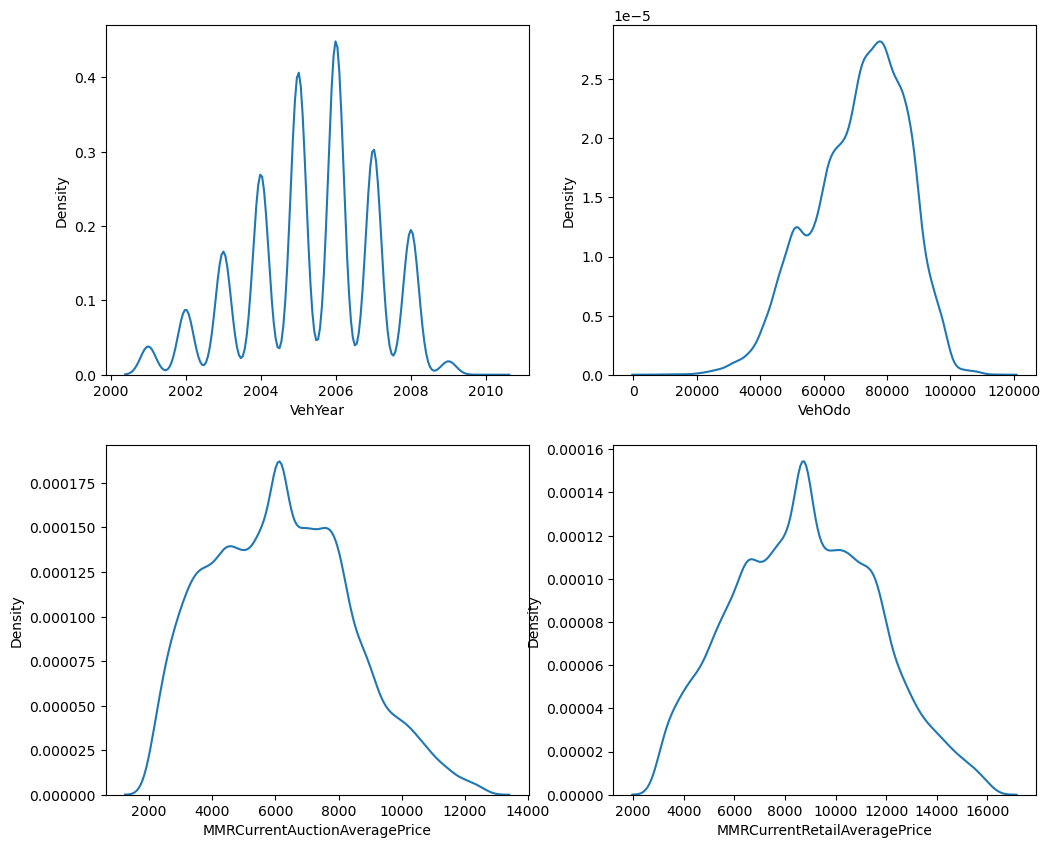

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_skewed_columns(df):
    f, axes = plt.subplots(2,2, figsize=(12,10), sharex=False)

    sns.kdeplot(df['VehYear'].dropna(), ax=axes[0,0])
    sns.kdeplot(df['VehOdo'].dropna(), ax=axes[0,1])
    sns.kdeplot(df['MMRCurrentAuctionAveragePrice'].dropna(), ax=axes[1,0])
    sns.kdeplot(df['MMRCurrentRetailAveragePrice'].dropna(), ax=axes[1,1])
    plt.show()
plot_skewed_columns(df)

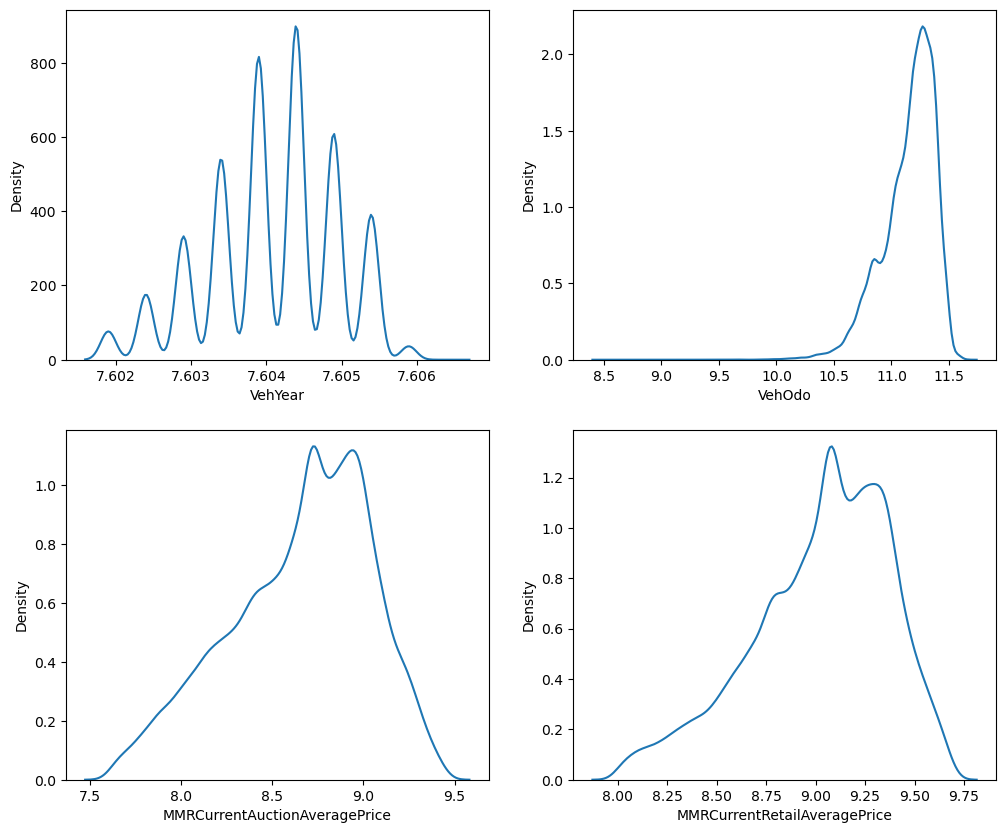

In [54]:
columns_to_transform = [
    'VehYear', 'VehOdo', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentRetailAveragePrice'
]

df_log = df.copy()

for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)

plot_skewed_columns(df_log)

In [55]:
y_log = df_log['IsBadBuy']
X_log = df_log.drop(['IsBadBuy'], axis=1)
X_mat_log = X_log.values
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, y_log,test_size=0.3, stratify=y_log, random_state=random_state)

scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)

In [56]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=random_state, class_weight='balanced'), 
                  cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

print("Train accuracy:", cv.score(X_train_log, y_train_log))
print("Test accuracy:", cv.score(X_test_log, y_test_log))

y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

print(cv.best_params_)

Train accuracy: 0.618916405469638
Test accuracy: 0.6204291569557181
              precision    recall  f1-score   support

           0       0.91      0.62      0.74     10832
           1       0.19      0.61      0.29      1611

    accuracy                           0.62     12443
   macro avg       0.55      0.62      0.52     12443
weighted avg       0.82      0.62      0.68     12443

{'C': 0.01}


In [57]:
from sklearn.feature_selection import RFECV
rfe = RFECV(estimator = LogisticRegression(random_state=random_state, class_weight='balanced'), cv=10)

rfe.fit(X_train, y_train)

print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 15
Number of features after elimination 2


In [58]:
selected_features = feature_names[rfe.support_]
print("Selected features: ", selected_features)

Selected features:  Index(['VehYear', 'Auction_MANHEIM'], dtype='object')


In [59]:
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

In [60]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

rfe_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=random_state, class_weight='balanced'), 
                  cv=10, n_jobs=-1)
rfe_cv.fit(X_train_sel, y_train)

print("Train accuracy:", rfe_cv.score(X_train_sel, y_train))
print("Test accuracy:", rfe_cv.score(X_test_sel, y_test))

y_pred = rfe_cv.predict(X_test_sel)
print(classification_report(y_test, y_pred))

print(rfe_cv.best_params_)

Train accuracy: 0.6316949677952675
Test accuracy: 0.6333681588041469
              precision    recall  f1-score   support

           0       0.91      0.64      0.75     10832
           1       0.19      0.57      0.29      1611

    accuracy                           0.63     12443
   macro avg       0.55      0.61      0.52     12443
weighted avg       0.82      0.63      0.69     12443

{'C': 0.001}


In [61]:
# running RFE + log transformation
rfe_log = RFECV(estimator = LogisticRegression(random_state=random_state, class_weight='balanced'), 
                cv=5)
rfe_log.fit(X_train_log, y_train_log)

print("Original feature set", X_train_log.shape[1])
print("Number of features after elimination", rfe.n_features_)

X_train_sel_log = rfe_log.transform(X_train_log)
X_test_sel_log = rfe_log.transform(X_test_log)

params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
rfe_log_cv = GridSearchCV(param_grid=params,
                          estimator=LogisticRegression(random_state=random_state, class_weight='balanced'), 
                          cv=10, n_jobs=-1)
rfe_log_cv.fit(X_train_sel_log, y_train_log)


print("Train accuracy:", rfe_log_cv.score(X_train_sel_log, y_train_log))
print("Test accuracy:", rfe_log_cv.score(X_test_sel_log, y_test_log))

y_pred_log = rfe_log_cv.predict(X_test_sel_log)
print(classification_report(y_test_log, y_pred_log))

print("Best parameters:", rfe_log_cv.best_params_)

Original feature set 15
Number of features after elimination 2
Train accuracy: 0.6316949677952675
Test accuracy: 0.6333681588041469
              precision    recall  f1-score   support

           0       0.91      0.64      0.75     10832
           1       0.19      0.57      0.29      1611

    accuracy                           0.63     12443
   macro avg       0.55      0.61      0.52     12443
weighted avg       0.82      0.63      0.69     12443

Best parameters: {'C': 0.001}


In [62]:
import pickle
with open('decision_tree_model.pickle','rb') as f:
    dt_best, roc_index_dt_cv, fpr_dt_cv, tpr_dt_cv = pickle.load(f)

def display_feature_importances(model, feature_names, features_to_display=20):
    importances = model.feature_importances_

    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    indices = indices[:features_to_display]
    for i in indices:
        print(feature_names[i], ':', importances[i])
    print("Number of leaves:", model.get_n_leaves())

display_feature_importances(dt_best, feature_names)

VehYear : 0.7598540857360376
MMRCurrentAuctionAveragePrice : 0.1144055334609266
VehOdo : 0.07466742514630023
Auction_ADESA : 0.03162454160340716
Auction_MANHEIM : 0.019448414053328502
Nationality_TOP LINE ASIAN : 0.0
Nationality_UNKNOWN : 0.0
Transmission_MANUAL : 0.0
Transmission_UNKNOWN : 0.0
Nationality_AMERICAN : 0.0
Nationality_OTHER : 0.0
Nationality_OTHER ASIAN : 0.0
Auction_OTHER : 0.0
Transmission_AUTO : 0.0
MMRCurrentRetailAveragePrice : 0.0
Number of leaves: 8


In [63]:
from sklearn.feature_selection import SelectFromModel

selectmodel = SelectFromModel(dt_best, prefit=True)
X_train_sel_model = selectmodel.transform(X_train)
X_test_sel_model = selectmodel.transform(X_test)
print(X_train_sel_model.shape)

(29033, 3)


In [64]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

cv_sel_model = GridSearchCV(param_grid=params,
                            estimator=LogisticRegression(random_state=random_state, class_weight='balanced'), cv=10)
cv_sel_model.fit(X_train_sel_model, y_train)
print("Train accuracy:", cv_sel_model.score(X_train_sel_model, y_train))
print("Test accuracy:", cv_sel_model.score(X_test_sel_model, y_test))

y_pred = cv_sel_model.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))

print(cv_sel_model.best_params_)

Train accuracy: 0.60820445699721
Test accuracy: 0.6144016716225991
              precision    recall  f1-score   support

           0       0.91      0.62      0.74     10832
           1       0.19      0.60      0.29      1611

    accuracy                           0.61     12443
   macro avg       0.55      0.61      0.51     12443
weighted avg       0.82      0.61      0.68     12443

{'C': 0.001}


In [65]:
from sklearn.metrics import roc_auc_score

y_pred_proba_lr = model.predict_proba(X_test)
y_pred_proba_lr_cv = cv.predict_proba(X_test)
y_pred_proba_rfe_cv = rfe_cv.predict_proba(X_test_sel)
y_pred_proba_rfe_log_cv = rfe_log_cv.predict_proba(X_test_sel_log)
y_pred_proba_cv_sel_model = cv_sel_model.predict_proba(X_test_sel_model)

roc_index_lr = roc_auc_score(y_test, y_pred_proba_lr[:, 1])
roc_index_lr_cv = roc_auc_score(y_test, y_pred_proba_lr_cv[:, 1])
roc_index_rfe_cv = roc_auc_score(y_test, y_pred_proba_rfe_cv[:, 1])
roc_index_rfe_log_cv = roc_auc_score(y_test, y_pred_proba_rfe_log_cv[:, 1])
roc_index_cv_sel_model = roc_auc_score(y_test, y_pred_proba_cv_sel_model[:, 1])


print("ROC index on test for `model`:", roc_index_lr)
print("ROC index on test for `cv`:", roc_index_lr_cv)
print("ROC index on test for `rfe_cv`:", roc_index_rfe_cv)
print("ROC index on test for `rfe_log_cv`:", roc_index_rfe_cv)
print("ROC index on test for `cv_sel_model`:", roc_index_cv_sel_model)

ROC index on test for `model`: 0.6509347203999094
ROC index on test for `cv`: 0.6503698034286071
ROC index on test for `rfe_cv`: 0.6423366989961006
ROC index on test for `rfe_log_cv`: 0.6423366989961006
ROC index on test for `cv_sel_model`: 0.645443656380112


In [66]:
from sklearn.metrics import roc_curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr[:,1])
fpr_lr_cv, tpr_lr_cv, thresholds_lr_cv = roc_curve(y_test, y_pred_proba_lr_cv[:,1])
fpr_rfe_cv, tpr_rfe_cv, thresholds_rfe_cv = roc_curve(y_test, y_pred_proba_rfe_cv[:,1])
fpr_rfe_log_cv, tpr_rfe_log_cv, thresholds_rfe_log_cv = roc_curve(y_test, y_pred_proba_rfe_log_cv[:,1])
fpr_cv_sel_model, tpr_cv_sel_model, thresholds_cv_sel_model = roc_curve(y_test, y_pred_proba_cv_sel_model[:,1])

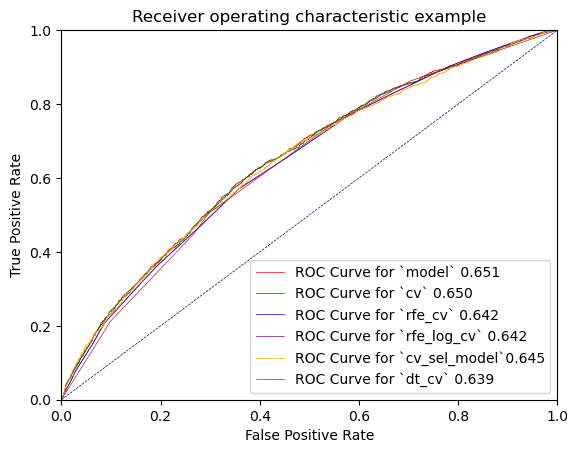

In [67]:
import matplotlib.pyplot as plt
plt.plot(fpr_lr, tpr_lr, label=f'ROC Curve for `model` {roc_index_lr:.3f}', color='red',lw=0.5)
plt.plot(fpr_lr_cv, tpr_lr_cv, label=f'ROC Curve for `cv` {roc_index_lr_cv:.3f}',color='green', lw=0.5)
plt.plot(fpr_rfe_cv, tpr_rfe_cv, label=f'ROC Curve for `rfe_cv` {roc_index_rfe_cv:.3f}',color='blue', lw=0.5)
plt.plot(fpr_rfe_log_cv, tpr_rfe_log_cv, label=f'ROC Curve for `rfe_log_cv` {roc_index_rfe_log_cv:.3f}', color='purple', lw=0.5)
plt.plot(fpr_cv_sel_model, tpr_cv_sel_model, label=f'ROC Curve for `cv_sel_model`{roc_index_cv_sel_model:.3f}', color='orange', lw=0.5)
plt.plot(fpr_dt_cv, tpr_dt_cv, label=f'ROC Curve for `dt_cv` {roc_index_dt_cv:.3f}', color='brown', lw=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

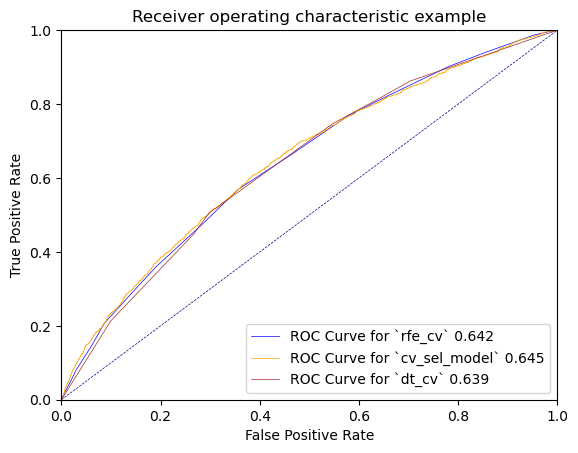

In [68]:
import matplotlib.pyplot as plt
plt.plot(fpr_rfe_cv, tpr_rfe_cv, label=f'ROC Curve for `rfe_cv` {roc_index_rfe_cv:.3f}', color='blue', lw=0.5)
plt.plot(fpr_cv_sel_model, tpr_cv_sel_model, label=f'ROC Curve for `cv_sel_model` {roc_index_cv_sel_model:.3f}', color='orange', lw=0.5)
plt.plot(fpr_dt_cv, tpr_dt_cv, label=f'ROC Curve for `dt_cv` {roc_index_dt_cv:.3f}', color='brown', lw=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [69]:
import pickle
lr_best = cv_sel_model
roc_index_lr_best = roc_index_cv_sel_model
tpr_lr_best = tpr_cv_sel_model
fpr_lr_best = fpr_cv_sel_model
with open('LR.pickle', 'wb') as f:
    pickle.dump([lr_best,roc_index_lr_best, fpr_lr_best, tpr_lr_best], f)

In [70]:
from sklearn.model_selection import train_test_split
random_state = 10
test_set_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=random_state)

print("Size of training set:", len(X_train))
print("Size of testing set:", len(X_test))

from sklearn.preprocessing import StandardScaler
random_seed = 10

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

Size of training set: 29033
Size of testing set: 12443


In [71]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

model = MLPClassifier(random_state=random_state)
model.fit(X_train, y_train)

MLPClassifier(random_state=10)

In [72]:
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.8706644163538043
Test accuracy: 0.8705296150446034
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10832
           1       0.00      0.00      0.00      1611

    accuracy                           0.87     12443
   macro avg       0.44      0.50      0.47     12443
weighted avg       0.76      0.87      0.81     12443



C:\Users\chj91\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chj91\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chj91\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [73]:
from imblearn.over_sampling import SMOTE
smote = SMOTE (random_state = 10)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# For fixing low precision, recall, f1-score
X_train_res = scaler.fit_transform(X_train_res) # scaling X_train_res

In [74]:
model = MLPClassifier(random_state=random_state)
model.fit(X_train_res, y_train_res)

C:\Users\chj91\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=10)

In [75]:
model = MLPClassifier(max_iter=500, random_state=random_state)
model.fit(X_train_res, y_train_res)

MLPClassifier(max_iter=500, random_state=10)

In [76]:
print("Train accuracy:", model.score(X_train_res, y_train_res))
print("Test accuracy:", model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.6623273849562774
Test accuracy: 0.5528409547536768
              precision    recall  f1-score   support

           0       0.91      0.54      0.68     10832
           1       0.17      0.63      0.27      1611

    accuracy                           0.55     12443
   macro avg       0.54      0.58      0.47     12443
weighted avg       0.81      0.55      0.63     12443



In [77]:
print(X_train.shape)
print(X_train_res.shape)

(29033, 15)
(50546, 15)


In [78]:
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

import os
os.environ["PYTHONWARNINGS"] = "ignore"
params = {'hidden_layer_sizes': [(x,) for x in range(16, 257, 16)]} 
cv_1 = GridSearchCV(param_grid=params,estimator=MLPClassifier(random_state=random_state), 
                    return_train_score=True, cv=10, n_jobs=-1)

cv_1.fit(X_train_res, y_train_res)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(16,), (32,), (48,), (64,),
                                                (80,), (96,), (112,), (128,),
                                                (144,), (160,), (176,), (192,),
                                                (208,), (224,), (240,),
                                                (256,)]},
             return_train_score=True)

In [79]:
result_set = cv_1.cv_results_
print(result_set)

{'mean_fit_time': array([ 5.04030867, 16.31987057, 21.07404983, 22.90560138, 26.57234924,
       28.70799239, 34.05265481, 36.82711794, 40.10747082, 42.22639754,
       44.58717003, 49.48394325, 53.54453709, 56.0687947 , 60.63102107,
       53.58457985]), 'std_fit_time': array([1.73023766, 3.03423766, 1.98232264, 1.17688553, 2.28457748,
       2.1550733 , 0.52705362, 0.54319134, 0.73249827, 3.06735333,
       3.08514969, 2.0742349 , 2.04220072, 2.19707525, 5.08192009,
       9.29926384]), 'mean_score_time': array([0.00177085, 0.00735428, 0.00483882, 0.00550468, 0.00555911,
       0.00451362, 0.00934517, 0.00932889, 0.00838771, 0.0089174 ,
       0.01380889, 0.00959959, 0.01291261, 0.01551218, 0.01308794,
       0.01060846]), 'std_score_time': array([0.00058577, 0.01372587, 0.00562463, 0.00417514, 0.0038522 ,
       0.00079888, 0.00643694, 0.00713027, 0.00818985, 0.00772222,
       0.00963663, 0.00182508, 0.01031701, 0.00877146, 0.00721633,
       0.00430817]), 'param_hidden_layer_sizes

Total number of models:  16


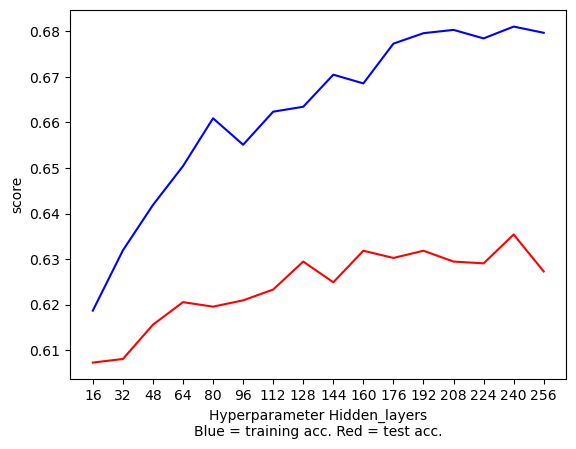

In [80]:
import matplotlib.pyplot as plt
train_result = result_set['split0_train_score']
test_result = result_set['split0_test_score']
print("Total number of models: ", len(test_result))

plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)),test_result, 'r')
plt.xlabel('Hyperparameter Hidden_layers\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),range(16, 257, 16))
plt.ylabel('score')
plt.show()

Total number of models:  16


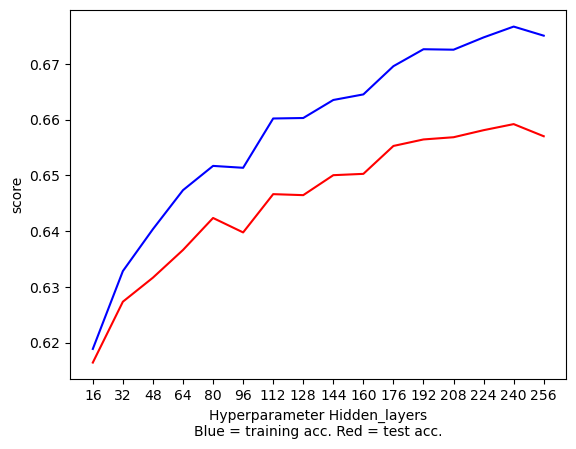

In [81]:
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))

plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)),test_result, 'r')
plt.xlabel('Hyperparameter Hidden_layers\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),range(16, 257, 16))
plt.ylabel('score')
plt.show()

In [82]:
print("Train accuracy:", cv_1.score(X_train_res, y_train_res))
print("Test accuracy:", cv_1.score(X_test, y_test))

y_pred = cv_1.predict(X_test)
print(classification_report(y_test, y_pred))
print(cv_1.best_params_)

Train accuracy: 0.6791239662881335
Test accuracy: 0.5979265450454071
              precision    recall  f1-score   support

           0       0.90      0.60      0.72     10832
           1       0.17      0.55      0.26      1611

    accuracy                           0.60     12443
   macro avg       0.54      0.58      0.49     12443
weighted avg       0.81      0.60      0.66     12443

{'hidden_layer_sizes': (240,)}


In [83]:
# new parameters
params = {'hidden_layer_sizes': [(12,), (16,), (24,), (32,), (40,), (48,), (56,), (64,)]}
cv_2 = GridSearchCV(param_grid=params,
                    estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)
cv_2.fit(X_train_res, y_train_res)

print("Train accuracy:", cv_2.score(X_train_res, y_train_res))
print("Test accuracy:", cv_2.score(X_test, y_test))

y_pred = cv_2.predict(X_test)
print(classification_report(y_test, y_pred))
print(cv_2.best_params_)

Train accuracy: 0.6450362046452736
Test accuracy: 0.5968014144498915
              precision    recall  f1-score   support

           0       0.91      0.60      0.72     10832
           1       0.18      0.58      0.27      1611

    accuracy                           0.60     12443
   macro avg       0.54      0.59      0.50     12443
weighted avg       0.81      0.60      0.66     12443

{'hidden_layer_sizes': (64,)}


In [84]:
params = {'hidden_layer_sizes': [(12,), (16,), (24,), (32,), (40,), (48,), (56,), (64,)], 
          'alpha': [0.01, 0.001, 0.0001, 0.00001]}
cv_3 = GridSearchCV(param_grid=params,
                    estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)
cv_3.fit(X_train_res, y_train_res)

print("Train accuracy:", cv_3.score(X_train_res, y_train_res))
print("Test accuracy:", cv_3.score(X_test, y_test))

y_pred = cv_3.predict(X_test)
print(classification_report(y_test, y_pred))
print(cv_3.best_params_)

Train accuracy: 0.6450362046452736
Test accuracy: 0.5968014144498915
              precision    recall  f1-score   support

           0       0.91      0.60      0.72     10832
           1       0.18      0.58      0.27      1611

    accuracy                           0.60     12443
   macro avg       0.54      0.59      0.50     12443
weighted avg       0.81      0.60      0.66     12443

{'alpha': 0.0001, 'hidden_layer_sizes': (64,)}


In [85]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfe = RFECV(estimator = LogisticRegression(random_state=random_state), cv=10)
rfe.fit(X_train_res, y_train_res)
print(rfe.n_features_)

7


In [86]:
X_train_rfe = rfe.transform(X_train_res)
X_test_rfe = rfe.transform(X_test)

params = {'hidden_layer_sizes': [(12,), (16,), (24,), (32,), (40,), (48,), (56,), (64,)], 
          'alpha': [0.01,0.001, 0.0001, 0.00001]}
rfe_cv = GridSearchCV(param_grid=params,
                      estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)
rfe_cv.fit(X_train_rfe, y_train_res)

print("Train accuracy:", rfe_cv.score(X_train_rfe, y_train_res))
print("Test accuracy:", rfe_cv.score(X_test_rfe, y_test))

y_pred = rfe_cv.predict(X_test_rfe)
print(classification_report(y_test, y_pred))
print(rfe_cv.best_params_)

Train accuracy: 0.636331262612274
Test accuracy: 0.5823354496504058
              precision    recall  f1-score   support

           0       0.91      0.58      0.71     10832
           1       0.18      0.62      0.28      1611

    accuracy                           0.58     12443
   macro avg       0.54      0.60      0.49     12443
weighted avg       0.82      0.58      0.65     12443

{'alpha': 0.001, 'hidden_layer_sizes': (64,)}


In [87]:
import pickle
from sklearn.feature_selection import SelectFromModel

with open('decision_tree_model.pickle', 'rb') as f:
    dt_best, roc_index_dt_cv, fpr_dt_cv, tpr_dt_cv = pickle.load(f)

selectmodel = SelectFromModel(dt_best, prefit=True)
X_train_sel_model = selectmodel.transform(X_train_res)
X_test_sel_model = selectmodel.transform(X_test)
print(X_train_sel_model.shape)

(50546, 3)


In [88]:
params = {'hidden_layer_sizes': [(12,), (16,), (24,), (32,), (40,), (48,), (56,), (64,)], 
          'alpha': [0.01,0.001, 0.0001, 0.00001]}
cv_sel_model = GridSearchCV(param_grid=params,
                            estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)
cv_sel_model.fit(X_train_sel_model, y_train_res)

print("Train accuracy:", cv_sel_model.score(X_train_sel_model, y_train_res))
print("Test accuracy:", cv_sel_model.score(X_test_sel_model, y_test))

y_pred = cv_sel_model.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))
print(cv_sel_model.best_params_)

Train accuracy: 0.6176354212004906
Test accuracy: 0.53612472876316
              precision    recall  f1-score   support

           0       0.92      0.51      0.66     10832
           1       0.18      0.71      0.28      1611

    accuracy                           0.54     12443
   macro avg       0.55      0.61      0.47     12443
weighted avg       0.82      0.54      0.61     12443

{'alpha': 1e-05, 'hidden_layer_sizes': (48,)}


In [89]:
result_set = cv_sel_model.cv_results_
print(result_set)

{'mean_fit_time': array([2.61307387, 3.32342095, 3.63224914, 3.08962176, 4.4553205 ,
       5.23221664, 6.60045223, 6.22275076, 2.44562135, 3.20581086,
       3.88655572, 3.51227219, 4.67376947, 6.13752983, 7.40744953,
       9.07539027, 2.30465395, 3.11088026, 4.10917952, 3.68202248,
       4.74791892, 6.74478827, 8.62274277, 9.00750089, 2.37436945,
       2.84029069, 3.78874242, 3.70845461, 4.73070049, 6.49653594,
       7.97357476, 7.25966299]), 'std_fit_time': array([0.57823516, 0.46740327, 0.68163409, 0.65513637, 0.84687678,
       0.63974642, 1.28869141, 1.27393113, 0.35588244, 0.51168574,
       0.80719121, 0.81530492, 1.45112898, 1.57729401, 1.77334466,
       3.26344989, 0.44077161, 0.53011522, 0.87284507, 0.91904397,
       1.31997798, 2.29811869, 2.91985707, 3.25020271, 0.41587588,
       0.46250677, 0.76785608, 0.73854205, 1.36864559, 1.53891117,
       2.05260287, 2.35091474]), 'mean_score_time': array([0.00160739, 0.00404949, 0.00202022, 0.0050524 , 0.00290947,
       0.0

ROC index on test for NN_default: 0.6187085509793728
ROC index on test for NN with gridsearch 1: 0.610088782163248
ROC index on test for NN with gridsearch 2: 0.624033601156011
ROC index on test for NN with gridsearch 3: 0.624033601156011
ROC index on test for NN with feature selection and gridsearch: 0.6377642697408052
ROC index on test for NN with feature selection (model selection) and gridsearch: 0.6471949677576704


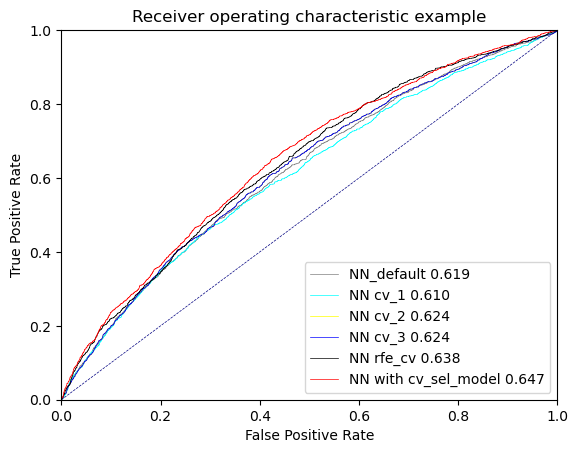

In [90]:
from sklearn.metrics import roc_auc_score

y_pred_proba_nn = model.predict_proba(X_test)
y_pred_proba_cv_1 = cv_1.predict_proba(X_test)
y_pred_proba_cv_2 = cv_2.predict_proba(X_test)
y_pred_proba_cv_3 = cv_3.predict_proba(X_test)
y_pred_proba_rfe_cv = rfe_cv.predict_proba(X_test_rfe)
y_pred_proba_cv_sel_model = cv_sel_model.predict_proba(X_test_sel_model)

roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])
roc_index_cv_1 = roc_auc_score(y_test, y_pred_proba_cv_1[:, 1])
roc_index_cv_2 = roc_auc_score(y_test, y_pred_proba_cv_2[:, 1])
roc_index_cv_3 = roc_auc_score(y_test, y_pred_proba_cv_3[:, 1])
roc_index_rfe_cv = roc_auc_score(y_test, y_pred_proba_rfe_cv[:, 1])
roc_index_cv_sel_model = roc_auc_score(y_test, y_pred_proba_cv_sel_model[:, 1])

print("ROC index on test for NN_default:", roc_index_nn)
print("ROC index on test for NN with gridsearch 1:", roc_index_cv_1)
print("ROC index on test for NN with gridsearch 2:", roc_index_cv_2)
print("ROC index on test for NN with gridsearch 3:", roc_index_cv_3)
print("ROC index on test for NN with feature selection and gridsearch:", roc_index_rfe_cv)
print("ROC index on test for NN with feature selection (model selection) and gridsearch:", roc_index_cv_sel_model)

from sklearn.metrics import roc_curve
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])
fpr_cv_1, tpr_cv_1, thresholds_cv_1 = roc_curve(y_test, y_pred_proba_cv_1[:,1])
fpr_cv_2, tpr_cv_2, thresholds_cv_2 = roc_curve(y_test, y_pred_proba_cv_2[:,1])
fpr_cv_3, tpr_cv_3, thresholds_cv_3 = roc_curve(y_test, y_pred_proba_cv_3[:,1])
fpr_rfe_cv, tpr_rfe_cv, thresholds_rfe_cv = roc_curve(y_test, y_pred_proba_rfe_cv[:,1])
fpr_cv_sel_model, tpr_cv_sel_model, thresholds_cv_sel_model = roc_curve(y_test, y_pred_proba_cv_sel_model[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr_nn, tpr_nn, label='NN_default {:.3f}'.format(roc_index_nn), color='gray', lw=0.5)
plt.plot(fpr_cv_1, tpr_cv_1, label='NN cv_1 {:.3f}'.format(roc_index_cv_1), color='cyan', lw=0.5)
plt.plot(fpr_cv_2, tpr_cv_2, label='NN cv_2 {:.3f}'.format(roc_index_cv_2), color='yellow', lw=0.5)
plt.plot(fpr_cv_3, tpr_cv_3, label='NN cv_3 {:.3f}'.format(roc_index_cv_3), color='blue', lw=0.5)
plt.plot(fpr_rfe_cv, tpr_rfe_cv, label='NN rfe_cv {:.3f}'.format(roc_index_rfe_cv), color='black', lw=0.5)
plt.plot(fpr_cv_sel_model, tpr_cv_sel_model, label='NN with cv_sel_model {:.3f}'.format(roc_index_cv_sel_model), color='red', lw=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ROC index on test for decision tree: 0.6386763716857975
ROC index on test for linear regression: 0.645443656380112
ROC index on test for NN with feature selection (model selection) and gridsearch: 0.6471949677576704


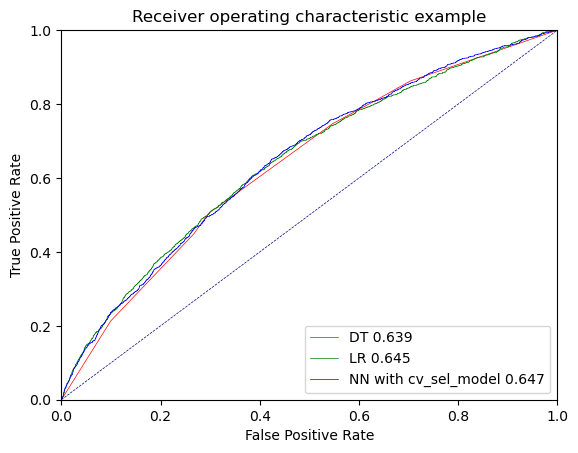

In [91]:
import pickle

with open('decision_tree_model.pickle', 'rb') as f:
    dt_best, roc_index_dt_cv, fpr_dt_cv, tpr_dt_cv = pickle.load(f)  
with open('LR.pickle', 'rb') as f:
    lr_best, roc_index_lr_cv, fpr_lr_cv, tpr_lr_cv = pickle.load(f)
    
print("ROC index on test for decision tree:", roc_index_dt_cv)
print("ROC index on test for linear regression:", roc_index_lr_cv)
print("ROC index on test for NN with feature selection (model selection) and gridsearch:", roc_index_cv_sel_model)

plt.plot(fpr_dt_cv, tpr_dt_cv, label='DT {:.3f}'.format(roc_index_dt_cv), color='red', lw=0.5)
plt.plot(fpr_lr_cv, tpr_lr_cv, label='LR {:.3f}'.format(roc_index_lr_cv), color='green', lw=0.5)
plt.plot(fpr_cv_sel_model, tpr_cv_sel_model, label='NN with cv_sel_model {:.3f}'.format(roc_index_cv_sel_model), color='blue', lw=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset as TorchDataset, DataLoader
from sklearn.metrics import accuracy_score

class MyNet(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        hidden_layer_size = 100
        output_size = 1
        self.fc1 = nn.Linear(in_features, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, data):
        data = F.relu(self.fc1(data))
        data = self.fc2(data)
        data = F.sigmoid(data)
        return torch.flatten(data)

In [93]:
# Custom Dataset class that inherits from PyTorch's Dataset class
class MyDataset(TorchDataset):
    def __init__(self, X, y):
        assert (len(X) == len(y))
        self.X = X.astype("float32")
        self.y = y.astype("float32")
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

In [94]:
# High-level model class that handles training and prediction
class MyModel:
    def __init__(self, in_features, batch_size=200):
        self.model = MyNet(in_features=in_features)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        self.criterion = nn.BCELoss()
        self.batch_size = batch_size
        count = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"The model has {count:,} trainable parameters")
        
    def train_one_epoch(self, loader):
        for X, y in loader:
            out = self.model(X)
            loss = self.criterion(out, y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
    def train(self, X_train, y_train, X_test, y_test, num_epochs=100):
        train_loader = DataLoader(MyDataset(X_train, y_train), batch_size=self.batch_size)
        train_acc_history = []
        test_acc_history = []
        
        for i in range(num_epochs):
            self.train_one_epoch(train_loader)
            train_pred = self.predict(X_train)
            train_acc = accuracy_score(y_train, train_pred)
            test_pred = self.predict(X_test)
            test_acc = accuracy_score(y_test, test_pred)
            print(f"Epoch {i+1}: Train Accuracy: {train_acc} Test Accuracy: {test_acc}")
            train_acc_history.append(train_acc)
            test_acc_history.append(test_acc)
        return (train_acc_history, test_acc_history)
        
    def predict(self, X):
        loader = DataLoader(MyDataset(X, X), batch_size=self.batch_size, shuffle=False)
        results = []
        for X_batch, _ in loader:
            out = self.model(X_batch)
            out = [1 if x >= 0.5 else 0 for x in out.tolist()]
            results.extend(out)
        return results

In [95]:
num_features = X_train.shape[1]
model = MyModel(num_features)

train_acc_list, test_acc_list = model.train(
    X_train_res, y_train_res, 
    X_test, y_test,
    num_epochs=200
)

The model has 1,701 trainable parameters
Epoch 1: Train Accuracy: 0.4791477070391327 Test Accuracy: 0.4117174314875834
Epoch 2: Train Accuracy: 0.5741502789538242 Test Accuracy: 0.3955637707948244
Epoch 3: Train Accuracy: 0.5887508408182646 Test Accuracy: 0.41661978622518686
Epoch 4: Train Accuracy: 0.596624856566296 Test Accuracy: 0.435988105762276
Epoch 5: Train Accuracy: 0.5999683456653345 Test Accuracy: 0.44699831230410675
Epoch 6: Train Accuracy: 0.602678748071064 Test Accuracy: 0.4559189905971229
Epoch 7: Train Accuracy: 0.6037866497843548 Test Accuracy: 0.4617053765169171
Epoch 8: Train Accuracy: 0.604617576069323 Test Accuracy: 0.46564333360122157
Epoch 9: Train Accuracy: 0.6052308788034662 Test Accuracy: 0.46845616009001045
Epoch 10: Train Accuracy: 0.6070312190875639 Test Accuracy: 0.4703849553966085
Epoch 11: Train Accuracy: 0.6080995528825228 Test Accuracy: 0.4718315518765571
Epoch 12: Train Accuracy: 0.608930479167491 Test Accuracy: 0.4737603471831552
Epoch 13: Train Accur

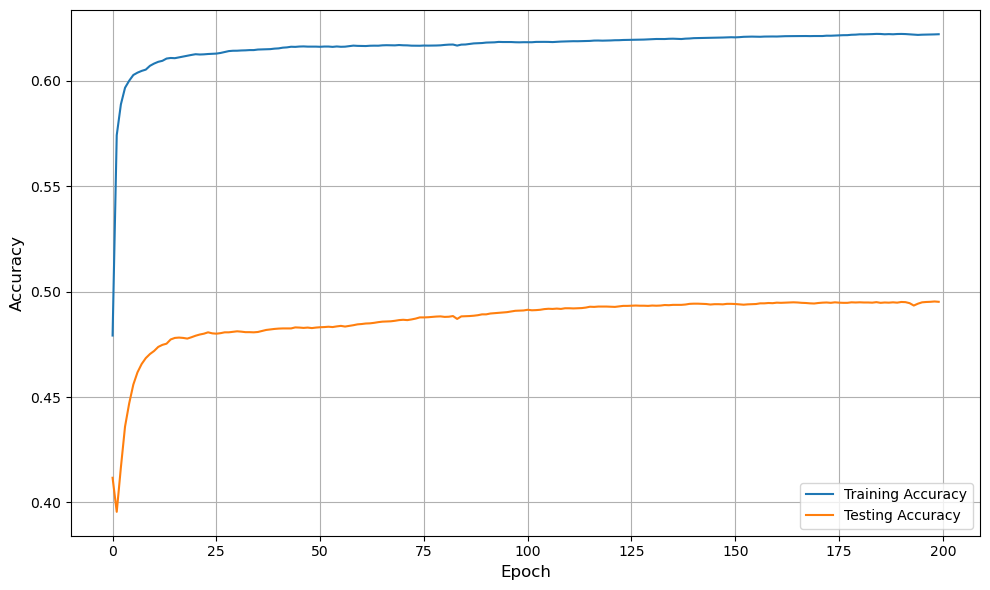

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.xlabel("Epoch", size=12)
plt.ylabel("Accuracy", size=12)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(test_acc_list, label="Testing Accuracy")
plt.grid()
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [97]:
epoch_with_highest_accuracy = np.argmax(test_acc_list) + 1
print(f"Epoch with highest accuracy: {epoch_with_highest_accuracy}")

Epoch with highest accuracy: 199
